In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

class Stacking(BaseEstimator, ClassifierMixin):  

    def __init__(self, models, ens_model):
       
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=3, err=0.001, random_state=None):
       
        if (p > 0): 
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict(valid)
                
            self.ens_model.fit(self.valid, y_valid)
            
        else: 
            
            
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, method='predict')
                clf.fit(X, y)
            
            self.ens_model.fit(self.valid, y)  
            

        return self

    def predict(self, X, y=None):
        
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict(X)
        
        a = self.ens_model.predict(X_meta)
        
        return (a)

In [4]:
from sklearn.metrics import roc_auc_score

def run_and_plot(clf, X, y, label):    
    a = clf.predict(X)
    
    xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
 
    print (label + ' AUC-ROC  = ' + str( roc_auc_score(y, a) ))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 7))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 20), cmap=plt.cm.bwr, alpha=0.3)
   

    plt.scatter(X[:300, 0], X[:300, 1], c=y[:300], s=20, alpha=1.0)
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.title(label)

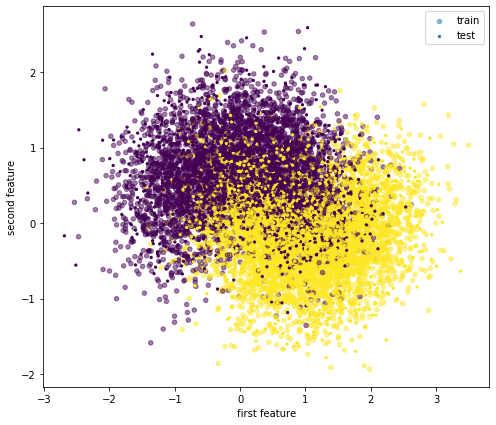

In [5]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_classification

X, y = make_moons(10000, noise=0.5)


train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.7, random_state=1999)

plt.figure(figsize=(8, 7))
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=20, alpha=0.5, label='train')
plt.scatter(test_X[:, 0], test_X[:, 1], c=test_y, s=5, alpha=1.0, label='test')
plt.xlabel("first feature")
plt.ylabel("second feature")
plt.legend()
plt.show()

3NN AUC-ROC  = 0.8505639916510213
10NN AUC-ROC  = 0.8889071122774082
ridge-0.01 AUC-ROC  = 0.8919761975877567
ridge-1.1 AUC-ROC  = 0.8919761975877567
ridge-100.1 AUC-ROC  = 0.8918948590487569
rf-d1 AUC-ROC  = 0.7967189900153611
rf-d5 AUC-ROC  = 0.9054726169141492


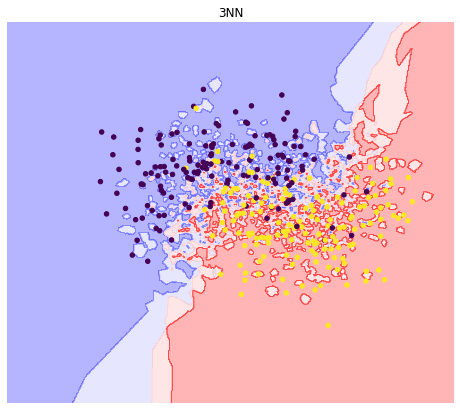

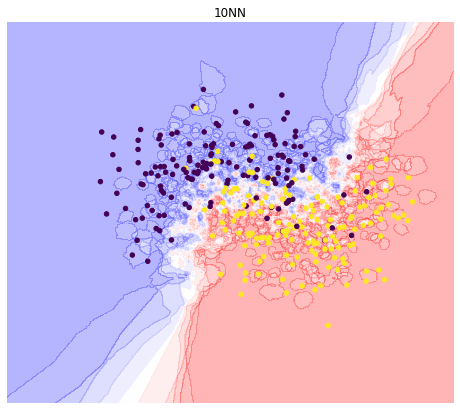

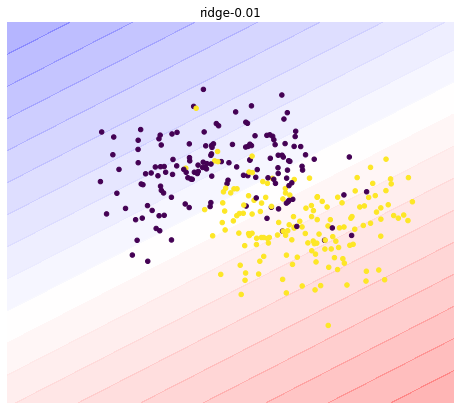

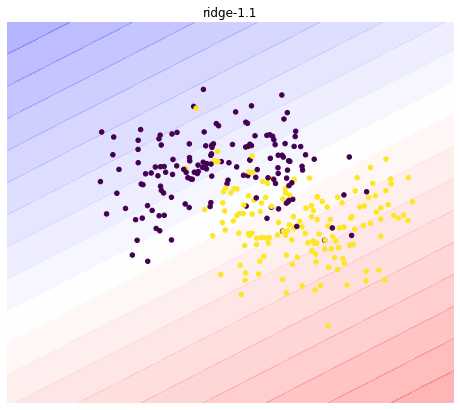

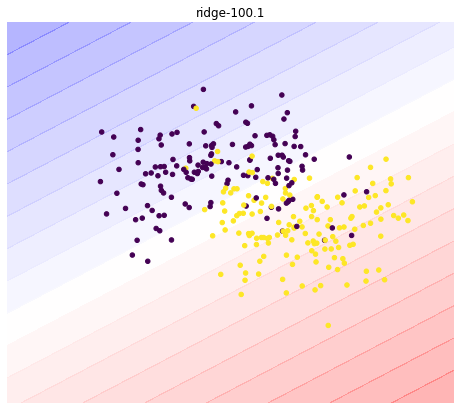

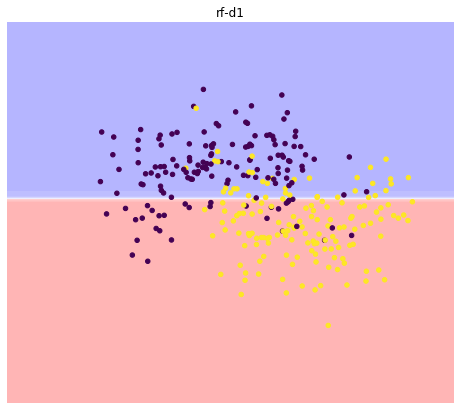

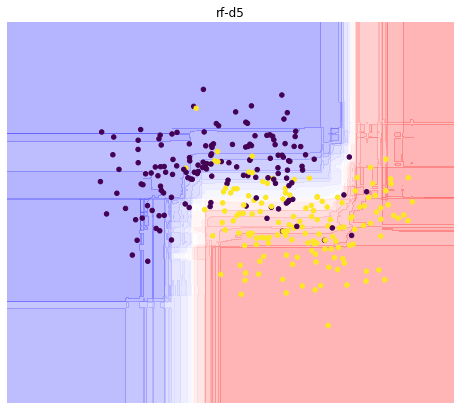

In [8]:
#import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

knn1 = KNeighborsRegressor(n_neighbors=3)
knn1.fit(train_X, train_y)
run_and_plot(knn1, test_X, test_y, '3NN')

knn2 = KNeighborsRegressor(n_neighbors=10)
knn2.fit(train_X, train_y)
run_and_plot(knn2, test_X, test_y, '10NN')


rg0 = Ridge(alpha=0.01)
rg0.fit(train_X, train_y)
run_and_plot(rg0, test_X, test_y, 'ridge-0.01')

rg1 = Ridge(alpha=1.1)
rg1.fit(train_X, train_y)
run_and_plot(rg1, test_X, test_y, 'ridge-1.1')

rg2 = Ridge(alpha=100.1)
rg2.fit(train_X, train_y)
run_and_plot(rg2, test_X, test_y, 'ridge-100.1')


rf1 = RandomForestRegressor(n_estimators=100, max_depth=1)
rf1.fit(train_X, train_y)
run_and_plot(rf1, test_X, test_y, 'rf-d1')

rf2 = RandomForestRegressor(n_estimators=100, max_depth=5)
rf2.fit(train_X, train_y)
run_and_plot(rf2, test_X, test_y, 'rf-d5')


#gbm1 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.05, max_depth=2, n_estimators=200, nthread=-1, objective='regression')    
#gbm1.fit(train_X, train_y)
#run_and_plot(gbm1, test_X, test_y, 'gbm-d2')

#gbm2 = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.05, max_depth=5, n_estimators=200, nthread=-1, objective='regression')    
#gbm2.fit(train_X, train_y)
#run_and_plot(gbm2, test_X, test_y, 'gbm-d5')

1-stacking AUC-ROC  = 0.9047592379245605
2-stacking AUC-ROC  = 0.9045845600785117


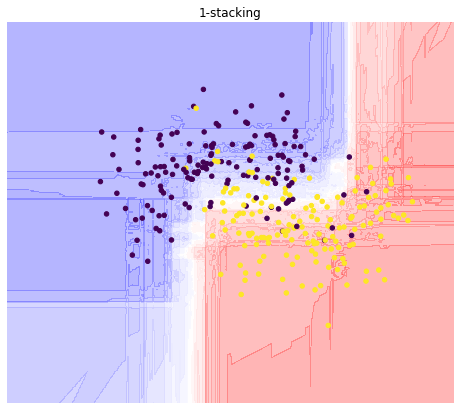

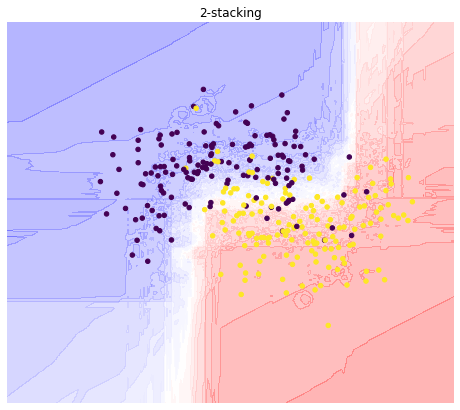

In [10]:
models = [knn1, knn2,rg1, rg2, rf1, rf2]  #, gbm1, gbm2
ens_model = Ridge()
s1 = Stacking(models, ens_model)
s1.fit(train_X, train_y)
run_and_plot(s1, test_X, test_y, '1-stacking')


s2 = Stacking(models, ens_model)
s2.fit(train_X, train_y, p=-1)
run_and_plot(s1, test_X, test_y, '2-stacking')

# 3NN AUC-ROC  = 0.775973303671
# 5NN AUC-ROC  = 0.807764182425
# 10NN AUC-ROC  = 0.832080088988
# 0-ridge AUC-ROC  = 0.860778642937
# 1-ridge AUC-ROC  = 0.860912124583
# 10-ridge AUC-ROC  = 0.860556173526
# 1-rf AUC-ROC  = 0.791879866518
# 3-rf AUC-ROC  = 0.840622914349
# 5-rf AUC-ROC  = 0.848743047831
# 1-stacking AUC-ROC  = 0.855884315907
# 2-stacking AUC-ROC  = 0.852413793103

In [11]:
ens_model = Ridge(0.001)
s1 = Stacking(models, ens_model)
a = 0
e = []
for t in range(10):
    s1.fit(train_X, train_y, p=0.4)
    a += s1.predict(test_X, train_y)
    
    auc = roc_auc_score(test_y, a)
    print (auc)
    e.append(auc)

0.9050717023667291
0.9060099846390168
0.9063126706775899
0.9060677661148092
0.9059615370939296
0.9058308620640609
0.905694853359504
0.9057815255731922
0.9056797412812198
0.9057953042328041


In [12]:
e4 = e

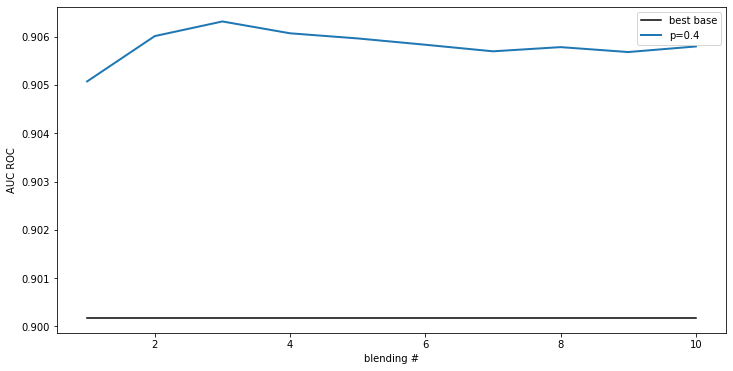

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1,11), 0.900175155867 + 0*np.arange(1,11), c='black', label='best base')
plt.plot(np.arange(1,11), e4, label='p=0.4', lw=2)
plt.xlabel(u'blending #')
plt.ylabel('AUC ROC')
plt.legend()

In [14]:
ens_model = Ridge(0.001)

s1 = Stacking(models, ens_model)
a = 0
e = []
for t in range(2, 11):
    s1.fit(train_X, train_y, p=-1, cv=t, err=0.00)
    a = s1.predict(test_X, train_y)
    auc = roc_auc_score(test_y, a)
    print (auc)
    e.append(auc)

0.9045414462081128
0.9047663494908118
0.9052690483302044
0.9048156859816807
0.905145484866587
0.9053010503783353
0.9050410337372703
0.905549510724242
0.9052894940831769


In [15]:
e1 = e

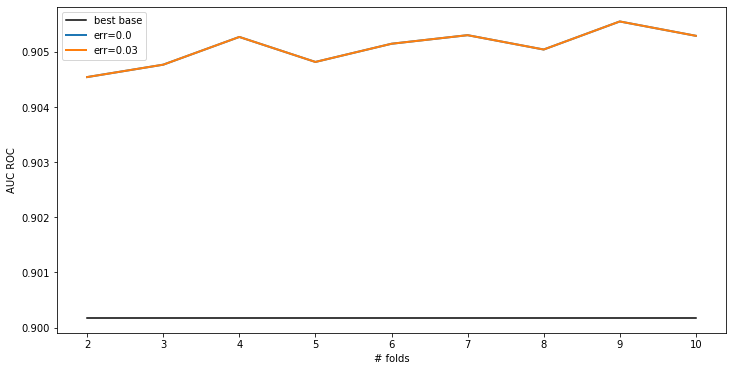

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(2,11), 0.900175155867 + 0*np.arange(2,11), c='black', label='best base')
plt.plot(np.arange(2,11), e1, label='err=0.0', lw=2)
plt.plot(np.arange(2,11), e1, label='err=0.03', lw=2)
plt.xlabel(u'# folds')
plt.ylabel('AUC ROC')
plt.legend()

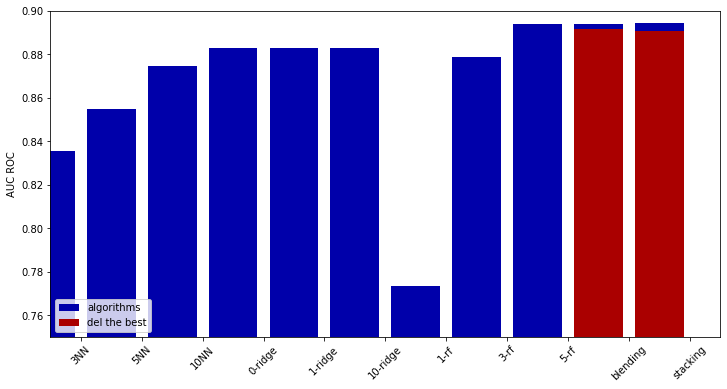

In [18]:
tmp = [('3NN', 0.83541103796),
       ('5NN', 0.854724379878),
       ('10NN', 0.874500610889),
       ('0-ridge', 0.883067503586),
       ('1-ridge', 0.883065725807),
       ('10-ridge', 0.88306217025),
       ('1-rf', 0.773247232554),
       ('3-rf', 0.878800390578),
       ('5-rf', 0.893922841743),
       ('blending', 0.893879508391),
       ('stacking', 0.89432173081)]


xticks = [x[0] for x in tmp]
aucs = [x[1] for x in tmp]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(aucs)), aucs, color='#0000AA', label=u'algorithms')
plt.xticks(np.arange(len(aucs))+0.5, xticks, rotation=45)

plt.bar([9, 10], [0.891809729693, 0.890628395835], color='#AA0000', label=u'del the best')


plt.xlim([0, 11])
plt.ylim([0.75, 0.9])
plt.ylabel('AUC ROC')
plt.legend(loc=3)